# Импорты

In [10]:
import multiprocessing as mp
import numpy as np
import ctypes as c

import pandas as pd
import seaborn as sns

import random
import time

from math import ceil

# Глобальные переменные

In [11]:
l = 200
min_a , max_a = 0,999
matrix_cut_num = 3

A = mp.Array('i', l*l)
B = mp.Array('i', l*l)

A_np = np.frombuffer(A.get_obj(), c.c_int).reshape((l,l))
B_np = np.frombuffer(B.get_obj(), c.c_int).reshape((l,l))
for i in range(l):
        for j in range(l):
            A_np[i][j] = random.randint(min_a, max_a)
            B_np[i][j] = random.randint(min_a, max_a)

C = mp.Array('i', l*l)
D_np = np.zeros(l*l).reshape((l,l))

# Обычное умножение

In [12]:
def mult_basic():
    for row_num in range(l):
        for col_num in range(l):
            s = 0
            for i in range(l):
                s += A_np[row_num][i] * \
                    B_np[i][col_num]
            D_np[row_num][col_num] = s


def go_basic():
    time_start = time.time()
    mult_basic()
    return (time.time() - time_start)

def mult_alt():
    for col_num in range(l):
        for row_num in range(l):
            s = 0
            for i in range(l):
                s += A_np[row_num][i] * \
                    B_np[i][col_num]
            D_np[row_num][col_num] = s

def go_alt():
    time_start = time.time()
    mult_alt()
    return (time.time() - time_start)

# Умножение в потоках

In [13]:
def mult_part(rows_start, rows_finish, columns_start, columns_finish):
    A.np = np.frombuffer(A.get_obj(), c.c_int).reshape((l,l))
    B_np = np.frombuffer(B.get_obj(), c.c_int).reshape((l,l))
    C_np = np.frombuffer(C.get_obj(), c.c_int).reshape((l,l))
    for row_num in range(rows_start, rows_finish):
        for col_num in range(columns_start, columns_finish):
            s = 0
            for i in range(l):
                s += A_np[row_num][i] * \
                    B_np[i][col_num]
            C_np[row_num][col_num] = s

            
def go_procs(procs_num):
    section_len = ceil(l/matrix_cut_num)
    cuts_left = list(range(0, l, section_len))
    cuts_right = list(range(section_len, l+ section_len, section_len))
    cuts_right[-1] = l
    parts = list(zip(cuts_left, cuts_right))
    
    args = []
    for x in parts:
        for y in parts:
            args.append((*x, *y))
            
    with mp.Pool(processes=procs_num) as p:
        time_start = time.time()
        res = p.starmap_async(mult_part, args)        
        res.get()
        p.close()
        p.join()

    return time.time() - time_start

# Запуск умножения в потоках

In [14]:
def compare_basic_and_procs(procs_num):
    t_base = go_basic()
    t_procs = go_procs(procs_num)
    comp = np.frombuffer(C.get_obj(), c.c_int).flatten() == D_np.flatten()
    assert comp.all()

    return t_base, t_procs


# Основная часть

In [15]:
# random.seed(42)

procs_num_list = []
base_times = []
proc_times = []

for procs_num in range(1, 10):
    procs_num_list.append(procs_num)
    t_base, t_procs = compare_basic_and_procs(procs_num)
    print(t_base, t_procs)
    base_times.append(t_base)
    proc_times.append(t_procs)

3.515106439590454 3.401228427886963
3.414888620376587 1.924285650253296
3.549649238586426 1.373678207397461
3.501690149307251 1.155695915222168
3.397756338119507 1.1512300968170166
3.4402313232421875 1.1415376663208008
3.394176483154297 1.1455769538879395
3.5501763820648193 1.2611401081085205
3.520455837249756 0.9361820220947266


,время обычное,время в потоках
1,3.515106,3.401228
2,3.414889,1.924286
3,3.549649,1.373678
4,3.501690,1.155696
5,3.397756,1.151230
6,3.440231,1.141538
7,3.394176,1.145577
8,3.550176,1.261140
9,3.520456,0.936182


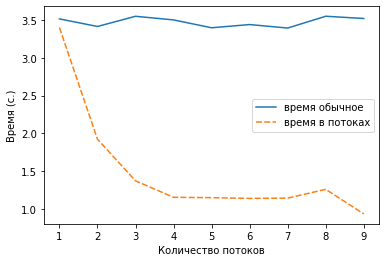

In [16]:
df = pd.DataFrame({
    'время обычное': base_times,
    'время в потоках': proc_times,
}, index = procs_num_list)

plot = sns.lineplot(df)
plot.set(xlabel="Количество потоков",
      ylabel="Время (с.)");
df

время обычного перемножения по столбцам и по строкам:

In [18]:
print(go_alt(), go_basic())

3.6578001976013184 3.638280153274536
